In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt
import random
import os
import numpy as np

## Custom Generator

In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, img_list, mask_dir, mask_list):
        self.img_dir = img_dir
        self.img_list = img_list
        self.mask_dir = mask_dir
        self.mask_list = mask_list

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_list[idx])

        image = np.load(img_name)
        mask = np.load(mask_name)

        return torch.from_numpy(image), torch.from_numpy(mask)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    dataset = CustomDataset(img_dir, img_list, mask_dir, mask_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [6]:
train_img_dir = "BraTS2021_TrainingData_2d/input_data_128/train/images/"
train_mask_dir = "BraTS2021_TrainingData_2d/input_data_128/train/masks/"

val_img_dir = "BraTS2021_TrainingData_2d/input_data_128/val/images/"
val_mask_dir = "BraTS2021_TrainingData_2d/input_data_128/val/masks/"

train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

TESTING THE GENERATOR on a training sample

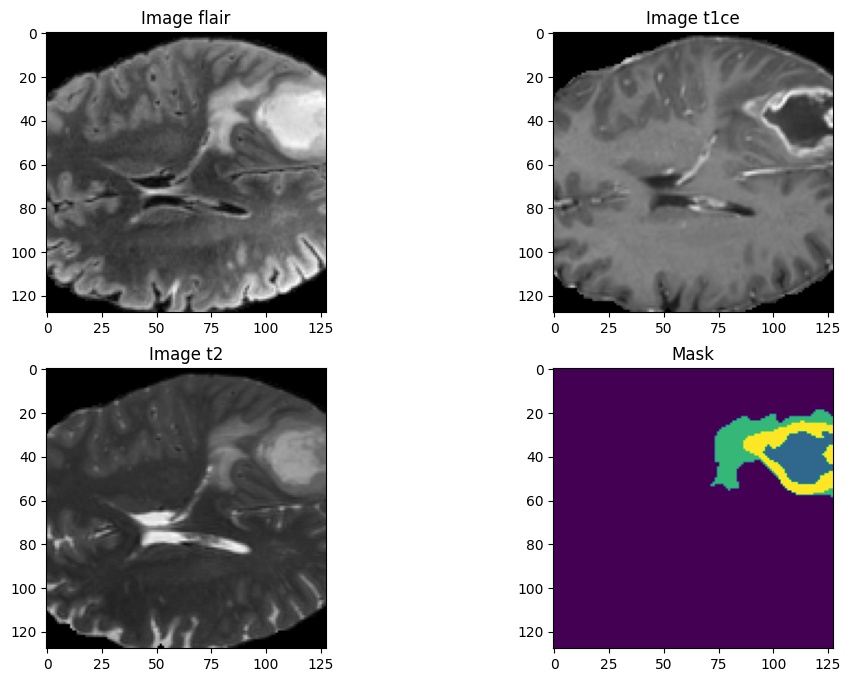

In [ ]:
for img, msk in train_img_datagen:
    break  # Break after the first batch

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=2)
#print(test_mask.shape) #--> torch.Size([128, 128])


#print(img.shape) #--> torch.Size([2, 128, 128, 3])
#print(test_img.shape) #--> torch.Size([128, 128, 3])

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:])
plt.title('Mask')
plt.show()

**Loss Function, Metrics, and Optimizer**:
- (Multiclass) Dice Loss is defined as the loss functions. 
- (Multiclass) IOU (Intersection over Union) is initially used for evaluation. (then we also integrate metrics such as Sensitivity, Specificity, Precision and F1 Score)
- Adam optimizer is utilized for optimization.

In [8]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiClassDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: [batch_size, num_classes, ...]
        # targets: [batch_size, num_classes, ...]

        dice_per_class = []
        for class_idx in range(inputs.size(1)):  # Iterate over classes
            
            class_inputs = inputs[:, class_idx, ...]
            class_targets = targets[:, class_idx, ...]

            # Compute Dice Loss for each class separately
            intersection = (class_inputs * class_targets).sum()
            dice = (2. * intersection + smooth) / (class_inputs.sum() + class_targets.sum() + smooth)
            dice_per_class.append(dice)

        # Average Dice Loss across all classes
        mean_dice_loss = torch.mean(torch.stack(dice_per_class))
        return 1 - mean_dice_loss


class MultiIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiIoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        IoU_per_class = []
        for class_idx in range(inputs.size(1)):
            class_inputs = inputs[:, class_idx, ...]
            class_targets = targets[:, class_idx, ...]

            intersection = (class_inputs * class_targets).sum() # True Positive count
            total = (class_inputs + class_targets).sum()
            union = total - intersection  # mutually inclusive area of all labels & predictions

            IoU = (intersection + smooth)/(union + smooth)
            IoU_per_class.append(IoU)

        mean_IoU_loss = torch.mean(torch.stack(IoU_per_class))

        return mean_IoU_loss  # will be used as accuracy --> reason why i don't do 1-score

### Model Definition and Initialization

In [10]:
from simple2DUNet import UNet_2d

model = UNet_2d()

### Hyperparameters

In [ ]:
LR = 0.0001
NUM_EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

multi_dice = MultiClassDiceLoss()
multi_IoU = MultiIoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_loss = []
train_acc = []

In [14]:
import csv
import os

train_log_path = 'training_statistics/train_log.csv' # file where to save training statistics we will need for plotting how loss and accuracy behave in 50 epochs

## training loop

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, masks in train_img_datagen:
        images = images.float().to(device=DEVICE)
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(masks, 1, -1), 2, -1)
        optimizer.zero_grad()
        preds = model(torch.transpose(torch.transpose(images, 1, -1), 2, -1))

        loss = multi_dice(preds,masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += multi_IoU(preds, masks).item()
        print("loss:", running_loss)

    epoch_loss = running_loss / len(train_img_datagen)
    epoch_accuracy = running_accuracy / len(train_img_datagen)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.4f}")


# Save the trained model
torch.save(model.state_dict(), 'models/brats_Unet2d.pth')
with open(train_log_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train_Loss', 'Train_Accuracy'])
    for e in range(epoch + 1):
        writer.writerow([e+1, train_loss[e], train_acc[e]])

Output streaming troncato alle ultime 5000 righe.
loss: 231.49110180139542
loss: 231.85340929031372
loss: 232.02936625480652
loss: 232.2011947631836
loss: 232.41516083478928
loss: 232.79500555992126
loss: 233.09124463796616
loss: 233.29809540510178
loss: 233.47103416919708
loss: 233.69647669792175
loss: 233.88587200641632
loss: 234.16154021024704
loss: 234.39840179681778
loss: 234.54496359825134
loss: 234.67424190044403
loss: 235.00250554084778
loss: 235.17519944906235
loss: 235.31995022296906
loss: 235.45991349220276
loss: 235.6236915588379
loss: 236.0605903863907
loss: 236.2022899389267
loss: 236.50944483280182
loss: 236.63839721679688
loss: 237.00995963811874
loss: 237.3096119761467
loss: 237.45932072401047
loss: 237.5831270813942
loss: 237.7324001789093
loss: 237.8414989709854
loss: 238.225472509861
loss: 238.42166393995285
loss: 238.61532181501389
loss: 238.70744663476944
loss: 238.93996566534042
loss: 239.16861814260483
loss: 239.33184444904327
loss: 239.49568343162537
loss: 239.

PLOTS


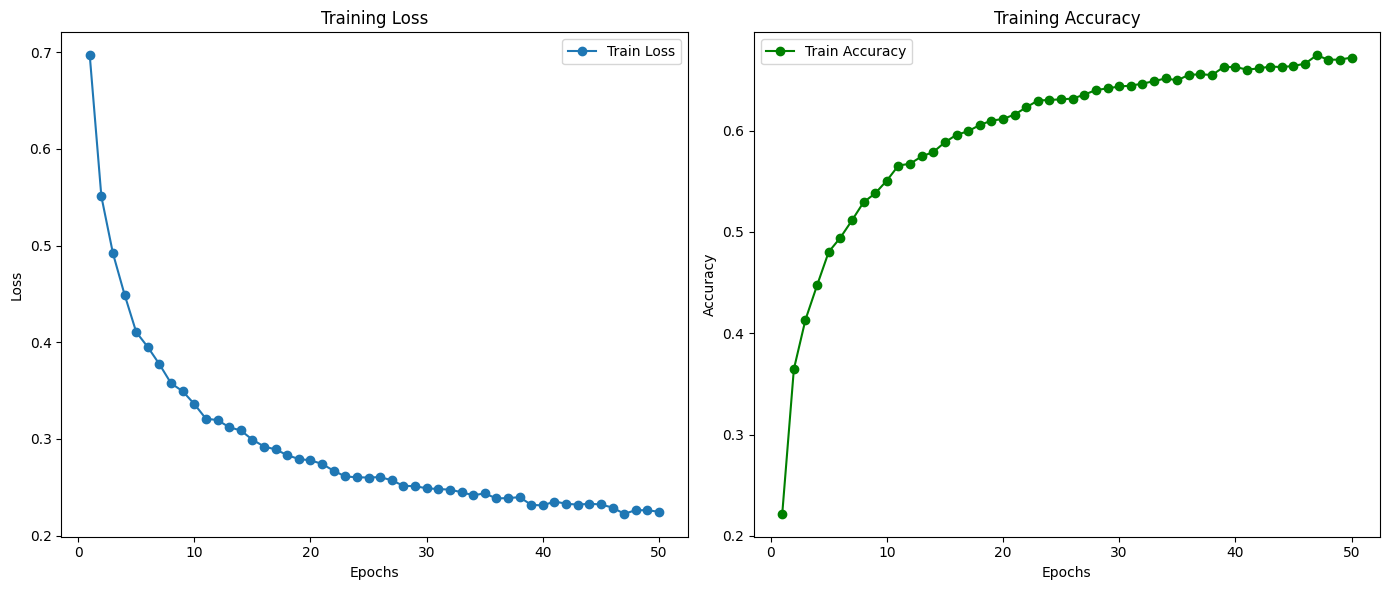

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
train_log_path = 'training_statistics/train_log.csv'
df = pd.read_csv(train_log_path)

# Extract columns for plotting
epochs = df['Epoch']
train_loss = df['Train_Loss']
train_accuracy = df['Train_Accuracy']

# Plot the training loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='-')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o', linestyle='-', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Validation on a single random sample

In [16]:
modelLoad = UNet_2d()

modelLoad.load_state_dict(torch.load('models/brats_Unet2d.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [37]:
for imgs, msks in val_img_datagen:
    break

#print(imgs.shape, msks.shape) # --> torch.Size([batch_size, 128, 128, 128, 3]) torch.Size([batch_size, 128, 128, 128, 4])

img_num = random.randint(0, imgs.size(0)-1)
val_img = imgs[img_num].unsqueeze(0)
val_msk = msks[img_num].unsqueeze(0)

#print(val_img.shape, val_msk.shape) # --> torch.Size([1, 128, 128, 3]) torch.Size([1, 128, 128, 4])

In [38]:
val_pred = modelLoad(torch.transpose(torch.transpose(torch.transpose(val_img.float(), 1, -1), 2, -1), 2, -2).to(device=DEVICE))
#print(val_pred.shape) # --> torch.Size([1, 4, 128, 128])

DICE SCORE ON THIS SINGLE PREDICTION:

In [39]:
DICE_SCORE = 1-multi_dice(val_pred, torch.transpose(torch.transpose(torch.transpose(val_msk, 1, -1), 2, -1), 2, -2))
print('DICE SCORE = ', DICE_SCORE.item())

DICE SCORE =  0.9194127321243286


adjust the image, target mask and predicted mask to display them using matplotlib

In [40]:
val_pred = val_pred[0] # shape = torch.Size([4, 128, 128])

In [41]:
val_pred = torch.transpose(torch.transpose(val_pred, 0, -1), 0, 1) # shape = torch.Size([128, 128, 4])
val_msk = val_msk[0] # shape = torch.Size([128, 128, 4])

In [42]:
val_img = val_img[0]
val_img = val_img.cpu().numpy()

In [43]:
val_pred = val_pred.cpu().detach().numpy()
val_msk = val_msk.cpu().numpy()

val_msk=np.argmax(val_msk, axis=2)
val_pred = np.argmax(val_pred, axis=2)

In [44]:
val, counts = np.unique(val_pred, return_counts=True)
print('prediction', val, counts)

val, counts = np.unique(val_msk, return_counts=True)
print('mask', val, counts)

prediction [0 1 2 3] [14708   470   691   515]
mask [0 1 2 3] [14807   489   541   547]


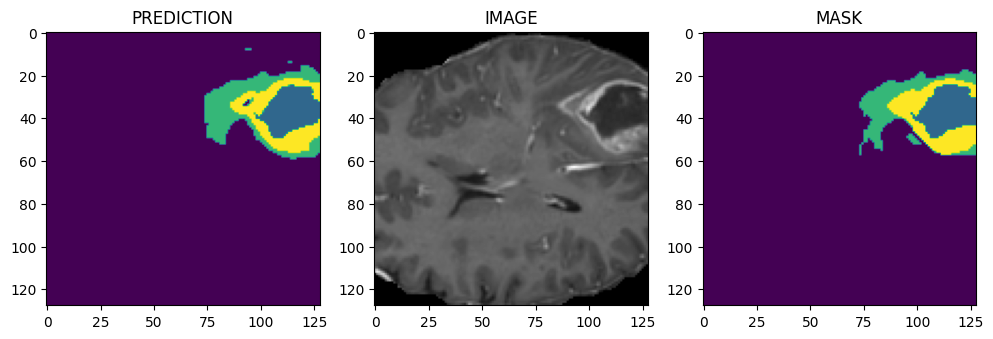

In [45]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(131)
plt.title('PREDICTION')
plt.imshow(val_pred[:,:])
plt.subplot(132)
plt.title('IMAGE')
plt.imshow(val_img[:,:,1], cmap='gray')
plt.subplot(133)
plt.title('MASK')
plt.imshow(val_msk[:,:])

### Validation loop

In [ ]:
with torch.no_grad():
    test_loss = 0
    test_acc = 0

    for images, masks in val_img_datagen:
        images = images.float().to(device=DEVICE)
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(masks, 1, -1), 2, -1)

        preds = model(torch.transpose(torch.transpose(images, 1, -1), 2, -1))

        loss = multi_dice(preds,masks)
        print('loss',loss.item())

        test_loss += loss.item()

        test_acc += multi_IoU(preds, masks).item()
        print('accuracy', multi_IoU(preds, masks).item())

    test_loss /= len(val_img_datagen)
    test_acc /= len(val_img_datagen)

In [ ]:
print('validation loss:', test_loss)
print('validation accuracy:', test_acc)

validation loss: 0.20930245251354584
validation accuracy: 0.6901156592408684


BUT we actually need to validate the model on volumes and not on slices to actually compare its performance to the one of the 3D model

## Validation on 3D volumes

Every slice of a single volume should be fed to the trained 2D model. Every output mask should be used to create a 3D volume representing the 3D mask of the initial sample volume.

### generator for 3D validation data

In [14]:
val_img_dir = "../architecture_3d/BraTS2021_TrainingData/input_data_128/val/images/"
val_mask_dir = "../architecture_3d/BraTS2021_TrainingData/input_data_128/val/masks/"

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

batch_size = 2

val_img_datagen_3d = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

### test on a single 3D sample

In [48]:
modelLoad = UNet_2d()

modelLoad.load_state_dict(torch.load('models/brats_Unet2d.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [66]:
for imgs, msks in val_img_datagen_3d:
    break

print(imgs.shape, msks.shape) # --> torch.Size([batch_size, 128, 128, 128, 3]) torch.Size([batch_size, 128, 128, 128, 4])

img_num = random.randint(0, imgs.size(0)-1) # taking one random volume from the batch
val_img = imgs[img_num].unsqueeze(0)
val_msk = msks[img_num].unsqueeze(0)

print(val_img.shape, val_msk.shape) # --> torch.Size([1, 128, 128, 3]) torch.Size([1, 128, 128, 4])

torch.Size([2, 128, 128, 128, 3]) torch.Size([2, 128, 128, 128, 4])
torch.Size([1, 128, 128, 128, 3]) torch.Size([1, 128, 128, 128, 4])


In [67]:
val_masks_3d = torch.zeros((1, 4, 128, 128, 128), device=DEVICE)
for slice in range(val_img.shape[3]):
    val_pred = modelLoad(torch.transpose(torch.transpose(torch.transpose(val_img[:,:,:,slice,:].float(), 1, -1), 2, -1), 2, -2).to(device=DEVICE))
    val_masks_3d[:, :, slice, :, :] = val_pred

print(val_masks_3d.shape)

torch.Size([1, 4, 128, 128, 128])


DICE SCORE ON THE ENTIRE PREDICTED VOLUME:

In [68]:
val_msks = torch.transpose(torch.transpose(torch.transpose(val_msk, 1, -1), 2, -1), 2, -2)
DICE_SCORE = 1 - multi_dice(val_masks_3d, val_msks)

print(DICE_SCORE.item())

0.7145971059799194


In [69]:
val_pred = val_masks_3d[0] # shape = torch.Size([4, 128, 128, 128])
val_msks = val_msks[0]
val_pred = torch.transpose(torch.transpose(torch.transpose(val_pred, 0, -1), 0, 2), 1, 2) # shape = torch.Size([128, 128, 128, 4])
val_msks = torch.transpose(torch.transpose(torch.transpose(val_msks, 0, -1), 0, 2), 1, 2) # shape = torch.Size([128, 128, 128, 4])

In [70]:
val_img = val_img[0]
val_img = val_img.cpu().numpy()
val_pred = val_pred.cpu().detach().numpy()
val_msks = val_msks.cpu().numpy()

val_msks = np.argmax(val_msks, axis=3)
val_pred = np.argmax(val_pred, axis=3)

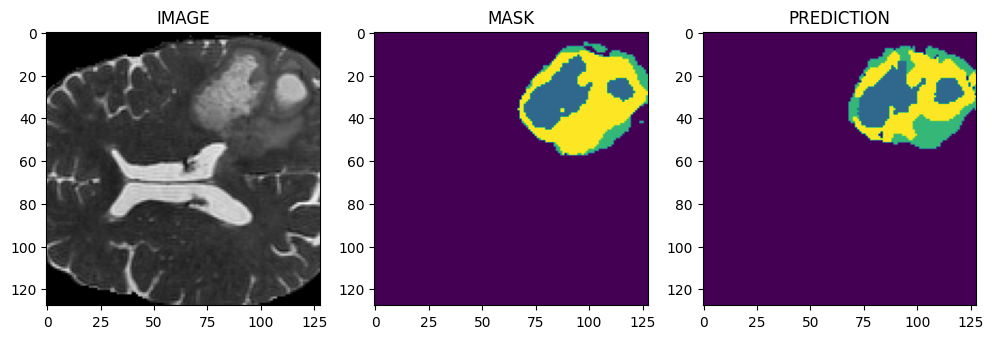

In [71]:
plt.figure(figsize=(12,6))

slice = 80

plt.subplot(131)
plt.title('IMAGE')
plt.imshow(val_img[:,:,slice,2], cmap='gray')
plt.subplot(132)
plt.title('MASK')
plt.imshow(val_msks[:,:,slice])
plt.subplot(133)
plt.title('PREDICTION')
plt.imshow(val_pred[:,:,slice])

here we show that each slice of the volume has its own prediction and there is actually continuity between the slices

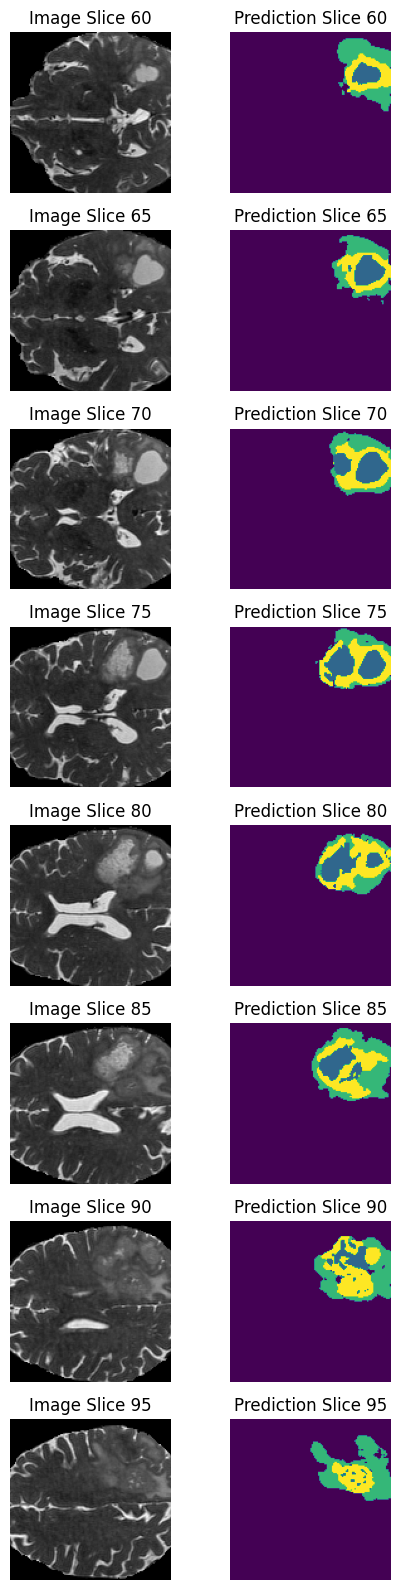

In [76]:
fig, axes = plt.subplots(8, 2, figsize=(5, 8 * 2))

skip = 5

for i in range(8):
    slice_idx = 55 + i + skip
    img_slice = val_img[:,:,slice_idx,2]  # Assuming the first channel for the image
    pred_slice = val_pred[:,:,slice_idx]  # Corresponding prediction slice

    axes[i, 0].imshow(img_slice, cmap='gray')
    axes[i, 0].set_title(f'Image Slice {slice_idx}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(pred_slice, cmap='viridis')
    axes[i, 1].set_title(f'Prediction Slice {slice_idx}')
    axes[i, 1].axis('off')

    skip +=4

plt.tight_layout()
plt.show()


## FINAL VALIDATION

In [78]:
modelLoad = UNet_2d()

modelLoad.load_state_dict(torch.load('models/brats_Unet2d.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [79]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
modelLoad.to(DEVICE)

multi_dice = MultiClassDiceLoss()
multi_IoU = MultiIoULoss()

DEFINITION of other important metrics: SENSITIVITY, SPECIFICITY, PRECISION, F1_SCORE

In [11]:
def compute_multiclass_metrics(preds, masks, num_classes, threshold=0.5):
    preds = (preds > threshold).float()
    masks = masks.float()

    sensitivity_sum = 0
    specificity_sum = 0
    precision_sum = 0
    f1_score_sum = 0

    for c in range(num_classes):

        # every metric is calculated for each class separately
        # (as a pixel-wise classification task) and then averaged
        
        pred_c = preds[:, c, :, :, :]
        mask_c = masks[:, c, :, :, :]

        TP = (pred_c * mask_c).sum().item()  # True Positives
        TN = ((1 - pred_c) * (1 - mask_c)).sum().item()  # True Negatives
        FP = (pred_c * (1 - mask_c)).sum().item()  # False Positives
        FN = ((1 - pred_c) * mask_c).sum().item()  # False Negatives

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        sensitivity_sum += sensitivity
        specificity_sum += specificity
        precision_sum += precision
        f1_score_sum += f1_score

    avg_sensitivity = sensitivity_sum / num_classes
    avg_specificity = specificity_sum / num_classes
    avg_precision = precision_sum / num_classes
    avg_f1_score = f1_score_sum / num_classes

    return avg_sensitivity, avg_specificity, avg_precision, avg_f1_score

In [ ]:
with torch.no_grad():
    test_loss = 0
    test_acc = 0
    sensitivity_sum = 0
    specificity_sum = 0
    precision_sum = 0
    f1_score_sum = 0


    for images, masks in val_img_datagen_3d:
        val_masks_3d = torch.zeros((2, 4, 128, 128, 128), device=DEVICE)
        for slice in range(images.shape[3]):
            val_pred = modelLoad(torch.transpose(torch.transpose(torch.transpose(images[:,:,:,slice,:].float(), 1, -1), 2, -1), 2, -2).to(device=DEVICE))
            val_masks_3d[:, :, slice, :, :] = val_pred
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(torch.transpose(masks, 1, -1), 2, -1), 2, -2)

        loss = multi_dice(val_masks_3d, masks)
        test_loss += loss.item()

        test_acc += multi_IoU(val_masks_3d, masks).item()
        print(test_acc)

        sensitivity, specificity, precision, f1_score = compute_multiclass_metrics(val_masks_3d, masks, 4)
        sensitivity_sum += sensitivity
        specificity_sum += specificity
        precision_sum += precision
        f1_score_sum += f1_score

    test_loss /= len(val_img_datagen_3d)
    test_acc /= len(val_img_datagen_3d)
    sensitivity_sum /= len(val_img_datagen_3d)
    specificity_sum /= len(val_img_datagen_3d)
    precision_sum /= len(val_img_datagen_3d)
    f1_score_sum /= len(val_img_datagen_3d)

In [83]:
import pandas as pd

# Define the metrics
metrics = {
    "Metric": ["Dice Score", "IoU Score", "Sensitivity", "Specificity", "Precision", "F1 Score"],
    "Value": [1-test_loss, test_acc, sensitivity_sum, specificity_sum, precision_sum, f1_score_sum]
}

# Create a DataFrame
df_metrics = pd.DataFrame(metrics)

styled_df = df_metrics.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background-color', '#101617'),
                ('font-weight', 'bold'),
                ('text-align', 'center')]},
     {'selector': 'td',
      'props': [('text-align', 'center')]}]
).set_properties(**{
    'border': '1px solid black',
    'padding': '6px'
}).set_caption("Model Performance")

styled_df

,Metric,Value
0,Dice Score,0.699996
1,IoU Score,0.578461
2,Sensitivity,0.811090
3,Specificity,0.956143
4,Precision,0.645264
5,F1 Score,0.702814


## ABLATION study

we modify the architecture by reducing the number of convolutional blocks from 5 to 3 (both in encoder and decoder)

feature channels before: [16, 32, 64, 128, 256, 512]
feature channels now: [16, 32, 64, 128]

In [1]:
from UNet_lesslayers import UNet_mod

In [10]:
modelLoad = UNet_mod()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
modelLoad.to(DEVICE)

modelLoad.load_state_dict(torch.load('models/brats_Unet2d_lesslayers.pth', map_location=torch.device(DEVICE)))

multi_dice = MultiClassDiceLoss()
multi_IoU = MultiIoULoss()

In [ ]:
with torch.no_grad():
    test_loss = 0
    test_acc = 0
    sensitivity_sum = 0
    specificity_sum = 0
    precision_sum = 0
    f1_score_sum = 0


    for images, masks in val_img_datagen_3d:
        val_masks_3d = torch.zeros((2, 4, 128, 128, 128), device=DEVICE)
        for slice in range(images.shape[3]):
            val_pred = modelLoad(torch.transpose(torch.transpose(torch.transpose(images[:,:,:,slice,:].float(), 1, -1), 2, -1), 2, -2).to(device=DEVICE))
            val_masks_3d[:, :, slice, :, :] = val_pred
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(torch.transpose(masks, 1, -1), 2, -1), 2, -2)

        loss = multi_dice(val_masks_3d, masks)
        test_loss += loss.item()

        test_acc += multi_IoU(val_masks_3d, masks).item()
        print(test_acc)

        sensitivity, specificity, precision, f1_score = compute_multiclass_metrics(val_masks_3d, masks, 4)
        sensitivity_sum += sensitivity
        specificity_sum += specificity
        precision_sum += precision
        f1_score_sum += f1_score

    test_loss /= len(val_img_datagen_3d)
    test_acc /= len(val_img_datagen_3d)
    sensitivity_sum /= len(val_img_datagen_3d)
    specificity_sum /= len(val_img_datagen_3d)
    precision_sum /= len(val_img_datagen_3d)
    f1_score_sum /= len(val_img_datagen_3d)

In [17]:
import pandas as pd

# Define the metrics
metrics = {
    "Metric": ["Dice Score", "IoU Score", "Sensitivity", "Specificity", "Precision", "F1 Score"],
    "Value": [1-test_loss, test_acc, sensitivity_sum, specificity_sum, precision_sum, f1_score_sum]
}

# Create a DataFrame
df_metrics = pd.DataFrame(metrics)

styled_df = df_metrics.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background-color', '#101617'),
                ('font-weight', 'bold'),
                ('text-align', 'center')]},
     {'selector': 'td',
      'props': [('text-align', 'center')]}]
).set_properties(**{
    'border': '1px solid black',
    'padding': '6px'
}).set_caption("Model Performance")

styled_df

,Metric,Value
0,Dice Score,0.602803
1,IoU Score,0.482531
2,Sensitivity,0.801412
3,Specificity,0.947466
4,Precision,0.533361
5,F1 Score,0.605777
